# Segmenting and Clustering Neighborhoods in Toronto, CA

## Author: Laila Linke

## Part 1: Webscraping and Data Cleaning
In this part of the notebook, we scrape the wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M to get the postal codes of neighborhoods in Toronto

In [1]:
# Import packages
import requests
import urllib.request
from urllib.request import urlopen
from bs4 import BeautifulSoup #For Datascraping
import pandas as pd

### Webscraping
We use BeautifulSoup to scrape the table from the Wikipedia page. For this, we first define the URL of the Wikipediapage and then use BeautifulSoup to read out the complete html page

In [2]:
# Define url with table
url=urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

In [3]:
# Read out website and store in soup object
soup = BeautifulSoup(url,'html.parser')

We find the table in the html page by searching for the keyword "table"

In [4]:
# Find table in soup object
table = soup.find('table')

We read out the table into three lists: one for each column. We find the elements of the table by looking for the keywords 'tr' and 'td'. 'tr' marks the beginning of a row, 'td' marks the beginning of a new cell inside a row. We iterate over all rows and write the value of the first cell into the list "postal_codes", the value of the second cell into the list "boroughs" and the value of the third cell into the list "neighborhoods".

In [5]:
#Create empty lists
postal_codes=[]
boroughs=[]
neighborhoods=[]

rows=table.find_all('tr') # Find all rows of the table
for row in rows: #Go through all rows of table
    cells=row.find_all('td') # Find all cells of this row
    for i, cell in enumerate(cells): # Go through all cells
        cell_val=cell.text.strip() # Strip whitespace
        if(i==0):
            postal_codes.append(cell_val) # Append first cell to "postal_codes"
        elif(i==1):
            boroughs.append(cell_val) # Append second cell to "boroughs"
        else:
            neighborhoods.append(cell_val) # Append third cell to "neighborhoods"

We convert the lists into a Pandas dataframe, which looks similar to the final expected dataframe.
Note however, that this dataframe still contains rows with "Not Assigned" boroughs and neighborhoods.

In [6]:
# Create Dataframe
df=pd.DataFrame()
df['PostalCode']=postal_codes
df['Borough']=boroughs
df['Neighborhood']=neighborhoods

df #Print Dataframe for visual inspection

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


### Data Cleaning
After scraping the complete table, we need to clean the data. We perform 2 steps, although the last step is not strictly necessary, as the Wikipedia table is already in the right format.

Step 1: We remove all rows whose Borough is not assigned

Step 2: For all rows, where the Borough is assigned, but the Neighborhood is not assigned, we set the Neighborhood to the Borough name. This is actually not necessary, because there are no cases in the Wikipedia table to which this applies

In [7]:
# Drop Not assigned Boroughs
mask=df['Borough']=='Not assigned' # Mask for values that should be dropped
df_cleaned=df.drop(df[mask].index) # Drop rows with unassigned boroughs and assign to new dataframe

# Set Neighborhood to Borough name, if Neighborhood is Not Assigned

def setNeighborhood(neighborhood, borough): #Define custom function that gives out borough name, if neighborhood is not assigned
    if neighborhood=='Not assigned':
        return borough
    else:
        return neighborhood

df_cleaned.loc[:,'Neighborhood']=[setNeighborhood(n, b) for n, b in (zip(df_cleaned['Neighborhood'], df_cleaned['Borough']))]

df_cleaned.reset_index(inplace=True) #Set new indices
df_cleaned.drop('index', inplace=True, axis=1) #Drop old indices
df_cleaned # Give out cleaned Dataframe

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [8]:
# Give out shape of cleaned Dataframe
df_cleaned.shape

(103, 3)

## Part 2: Getting Latitude and Longitude Data

In this part of the notebook, we assign each postal code a latitude and longitude. For this we use the geocoder package and the ArcGIS API. The Google API was unfortunately not available

In [9]:
#!pip install geocoder #uncomment to install geocoder package
import geocoder

First, we define a function that takes a postal code in Toronto 
and gives out the coordinates of the postal code. This uses geocoder and ArcGIS.

In [10]:
# Function that gives out coordinates for a given postal code
# Uses ArcGIS (World geocoding service) instead of Google API
def getCoordinates(postal_code):   
    coords=None
    while(coords==None): # Repeat call, until return is valid coordinate
        g=geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        coords=g.latlng
    return coords



Second, we read out the coordinates for all postal codes in the cleaned data frame

In [11]:
# Read out coordinates for all postal codes
coordinates=[getCoordinates(p) for p in df_cleaned.loc[:,'PostalCode']]

Lastly, we add the coordinates to the data frame

In [12]:
# Write coordinates into dataframe
df_cleaned.loc[:, 'Latitude']=[c[0] for c in coordinates]
df_cleaned.loc[:, 'Longitude']=[c[1] for c in coordinates]
df_cleaned

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.65319,-79.51113
99,M4Y,Downtown Toronto,Church and Wellesley,43.66659,-79.38133
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.64869,-79.38544
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.63278,-79.48945


We can now visualize the location of the neighborhoods using the folium library

In [13]:
import folium # for map visualization

In [14]:
# create map, centred on Toronto (coordinates from https://en.wikipedia.org/wiki/Toronto)
map_neighborhoods = folium.Map(location=[43.741667, -79.373333], zoom_start=11)

# add markers to the map
for lat, lon, name in zip(df_cleaned['Latitude'], df_cleaned['Longitude'], df_cleaned['Neighborhood']):
    label=folium.Popup(name, parse_html=True) # Add label with neighborhood name to each circle
    folium.CircleMarker([lat, lon], popup=label).add_to(map_neighborhoods)

map_neighborhoods

On the map, we can see, that the neighborhoods are not equally sized: In the city centre near the coast, the neighborhoods are much closer together, while they are more widespread in the outskirts of the city.

We also can pick three neighborhoods at different parts of the city:
- *Toronto Dominion Centre, Design Exchange* in the city centre
- *Rouge Hill, Port Union, Highland Creek* on the eastern side of the city
- *Northwest, West Humber - Clairville* on the western side of the city, near the International Airport

We will compare these three neighborhoods in the next part

### Part 3: Analysis of Torontos Neighborhoods
In this part we analyze the different neighborhoods, using Foursquare data. For this, we first identify which categories of venues are common in each neighborhood. We look at three example neighbourhoods to check which venues are common. Then, we cluster the neighborhoods according to their venues, using k-means clustering. We discuss which number of clusters is optimal for this analysis.

#### Part 3.1: Getting Foursquare venues for each neighborhood

We first define the Foursquare Credentials, so we can access the Foursquare API

In [15]:
# Foursquare credentials
CLIENT_ID = 'MSKA2MHIDITZYMFO2A42PE2SXYI2PWPXR24DBFLI43HN5Y14' # your Foursquare ID
CLIENT_SECRET = '25VATPCXE3W5SCML34NOTVM2BAHHQISAOJRE2FRV5JSKJJYN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MSKA2MHIDITZYMFO2A42PE2SXYI2PWPXR24DBFLI43HN5Y14
CLIENT_SECRET:25VATPCXE3W5SCML34NOTVM2BAHHQISAOJRE2FRV5JSKJJYN


We now define a function to get the 100 nearest venues in a region of 500 m around a given coordinate

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now, we get all venues for Torontos neighborhoods. I look at all neighborhoods with a Toronto Postal Code

In [17]:
venues=getNearbyVenues(df_cleaned['Neighborhood'], df_cleaned['Latitude'], df_cleaned['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

#### Part 3.2 Get frequency of each venue category per neighborhood

To get the most frequent venue category for each neighborhood, we first create a dataframe, where for each venue, a 1 marks the category (one-hot encoding)

In [18]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = venues['Neighborhood'] 


# move neighborhood column to the first column
venues_onehot.set_index('Neighborhood', inplace=True)
venues_onehot.reset_index(inplace=True)
venues_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now get the frequency of each category per neighborhood. For this, we group the dataset by neighborhood, and get the mean of venues per category and neighborhood. This tells us, which neighborhoods have many and which have only few venues of a certain category.

In [19]:
venues_grouped=venues_onehot.groupby('Neighborhood').mean()
venues_grouped.reset_index(inplace=True)
venues_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Agincourt,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.000000,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0
2,Bayview Village,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0
3,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0
4,Berczy Park,0.0,0.0,0.0,0.016667,0.0,0.016667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.016667,0.0


To explore single neighborhoods, we define a function that prints the most common venue categories in a neighborhood

In [20]:
# Takes a neighborhood (i.e. row in data frame) and returns the N most common venue categories
# Returns array with category names
def return_most_common_venues(neighborhood, N):
    categories = neighborhood.iloc[1:] #Read in categories of neighborhood
    categories_sorted = categories.sort_values(ascending=False) #Sort categories descending
    
    return categories_sorted.index.values[0:N] # Return category names

As an example, we will look at the three different neighborhoods we identified above as situated in different parts of Toronto: 
- *Toronto Dominion Centre, Design Exchange* in the city centre
- *Rouge Hill, Port Union, Highland Creek* on the eastern side of the city
- *Northwest, West Humber - Clairville* on the western side of the city, near the International Airport

In [21]:
# Toronto Dominion Centre, Design Exchange (City Centre)
print(return_most_common_venues(venues_grouped.set_index("Neighborhood").loc["Toronto Dominion Centre, Design Exchange"], 5))

['Coffee Shop' 'Hotel' 'Café' 'Restaurant' 'American Restaurant']


In [22]:
# Rouge Hill, Port Union, Highland Creek (East)
print(return_most_common_venues(venues_grouped.set_index("Neighborhood").loc["Rouge Hill, Port Union, Highland Creek"], 5))

['Construction & Landscaping' 'Bar' 'Farm' 'Elementary School'
 'Escape Room']


In [23]:
# Northwest, West Humber - Clairville (West, near airport)
print(return_most_common_venues(venues_grouped.set_index("Neighborhood").loc["Northwest, West Humber - Clairville"], 5))

['Middle Eastern Restaurant' 'Storage Facility' 'Gas Station' 'Restaurant'
 'Coffee Shop']


We can see that the three different neighborhoods have very different venues. In the city centre there are many Coffee shops/Cafés and Hotels, which is expected, as there are many tourists, visitors and business travellers in Torontos centre. The eastern outskirts are dominated by Landscaping shops, farms and elementary schools. This points to the fact, that these areas are mostly residential (suburban) areas. In the area near the international airport though we find several restaurants, which probably cater to people travelling at the airport. There are also storage facilities and gas stations, so this neighborhood is probably an industrial area.

#### Part 3.3. Clustering of Neighborhoods

Finally, we can cluster the neighborhoods according to the categories of their venues. For this, we use a k-means clustering algorithm. We arbitrarily set the number of clusters first to 5 (but will revisit this number later).

In [24]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

#venues_grouped.reset_index(inplace=True)
venues_grouped_clustering = venues_grouped.drop('Neighborhood', axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# add clustering labels
labels=pd.DataFrame() # Put labels in a data frame
labels['Neighborhood']=venues_grouped['Neighborhood']
labels['Cluster label']=kmeans.labels_
df_labeled = df_cleaned.join(labels.set_index('Neighborhood'), on='Neighborhood') # Add labels to df_cleaned
df_labeled.dropna(inplace=True) # drop NaN


To analyze what each cluster represents, we look at the most common venue categories of each cluster centre

In [25]:
import numpy as np

N=5

centers=kmeans.cluster_centers_
categories=venues_onehot.columns[1:]

for i, center in enumerate(centers):
    print("Cluster "+str(i))
    index_max=np.argmax(center)
    sorted_indices=np.argsort(-center)
    for j in sorted_indices[:N]:
        print("\t "+categories[j])

Cluster 0
	 Park
	 Construction & Landscaping
	 Grocery Store
	 Coffee Shop
	 Furniture / Home Store
Cluster 1
	 Coffee Shop
	 Pizza Place
	 Café
	 Sandwich Place
	 Bakery
Cluster 2
	 Park
	 Bakery
	 Food & Drink Shop
	 Residential Building (Apartment / Condo)
	 French Restaurant
Cluster 3
	 Trail
	 Accessories Store
	 Miscellaneous Shop
	 Mobile Phone Shop
	 Modern European Restaurant
Cluster 4
	 Auto Garage
	 Accessories Store
	 Mobile Phone Shop
	 Modern European Restaurant
	 Molecular Gastronomy Restaurant


The first cluster contains many parks, grocery stores and furniture stores, so it probably contains mostly suburban regions. In contrast, clusters 1 and 2 contain many restaurants and residential buildings, so these two clusters are probably denser populated and correspond to the city centre. Clusters 3 and 4 consist of multiple stores, so they might correspond to commercial zones / industrial areas.

To check whether these theories hold true, we visualize the clusters on the map using folium and different colors for the markers of each cluster

In [26]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map, centred on Toronto (coordinates from https://en.wikipedia.org/wiki/Toronto)
map_clusters = folium.Map(location=[43.741667, -79.373333], zoom_start=11)

# Define colors of circles
colors_array = cm.tab10(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, name, cluster in zip(df_labeled['Latitude'], df_labeled['Longitude'], df_labeled['Neighborhood'], df_labeled['Cluster label']):
    label=folium.Popup(name + ", cluster "+str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], popup=label, color=rainbow[int(cluster)-1]).add_to(map_clusters)

map_clusters

On the map we see that some of our theories were correct. Cluster 1 indeed contains most of the city centre, while cluster 0 contains the suburban areas. However, we cannot really see a trend for the other clusters. In particular, clusters 4 and 5 only contain one neighboorhood each. Therefore, it might be useful to change the value of k, to get more meaningful clusters

To find the best value of k, we calculate the "inertia" (i.e. the sum-of-squares of the distances of the neighborhoods to their cluster centres). This inertia shrinks with increasing k, however this decrease is faster for smaller k than for higher k, leading to an "elbow"-shape of the plot of k vs inertia. The best value for k is the value at the "turning point" of this elbow.

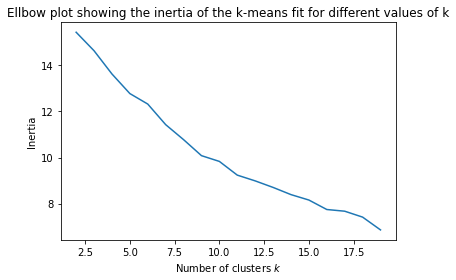

In [27]:
inertia=[] # List for inertia for each k
kclusters=range(2, 20) # List with different values of k we try out

from sklearn.metrics import silhouette_score

for k in kclusters: # Do k-means for different k values
    kmeans = KMeans(n_clusters=k, random_state=0).fit(venues_grouped_clustering)
    i=kmeans.inertia_
    inertia.append(i) # Add inertia to list
    
# Plot "Ellbow plot" k vs inertia
import matplotlib.pyplot as plt 
plt.xlabel(r'Number of clusters $k$')
plt.ylabel("Inertia")
plt.title('Ellbow plot showing the inertia of the k-means fit for different values of k')
plt.plot(kclusters, inertia)    
plt.show()


The plot does not give an umambiguos optimal value for k. However, the "turning point" is in between 7 and 10. We choose k=7 as optimal value and repeat the analysis from above for this value

In [28]:
# set number of clusters
kclusters = 7

#venues_grouped.reset_index(inplace=True)
venues_grouped_clustering = venues_grouped.drop('Neighborhood', axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# add clustering labels
labels=pd.DataFrame() # Put labels in a data frame
labels['Neighborhood']=venues_grouped['Neighborhood']
labels['Cluster label']=kmeans.labels_
df_labeled = df_cleaned.join(labels.set_index('Neighborhood'), on='Neighborhood') # Add labels to df_cleaned


df_labeled.dropna(inplace=True)
N=5

centers=kmeans.cluster_centers_
categories=venues_onehot.columns[1:]

for i, center in enumerate(centers):
    print("Cluster "+str(i))
    index_max=np.argmax(center)
    sorted_indices=np.argsort(-center)
    for j in sorted_indices[:N]:
        print("\t "+categories[j])

# create map, centred on Toronto (coordinates from https://en.wikipedia.org/wiki/Toronto)
map_clusters = folium.Map(location=[43.741667, -79.373333], zoom_start=11)

# Define colors of circles
colors_array = cm.tab10(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, name, cluster in zip(df_labeled['Latitude'], df_labeled['Longitude'], df_labeled['Neighborhood'], df_labeled['Cluster label']):
    label=folium.Popup(name + ", cluster "+str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], popup=label, color=rainbow[int(cluster)-1]).add_to(map_clusters)

map_clusters

Cluster 0
	 Park
	 Construction & Landscaping
	 Grocery Store
	 Coffee Shop
	 Furniture / Home Store
Cluster 1
	 Coffee Shop
	 Pizza Place
	 Café
	 Sandwich Place
	 Bakery
Cluster 2
	 Park
	 Bakery
	 Food & Drink Shop
	 Residential Building (Apartment / Condo)
	 French Restaurant
Cluster 3
	 Trail
	 Accessories Store
	 Miscellaneous Shop
	 Mobile Phone Shop
	 Modern European Restaurant
Cluster 4
	 Auto Garage
	 Accessories Store
	 Mobile Phone Shop
	 Modern European Restaurant
	 Molecular Gastronomy Restaurant
Cluster 5
	 Playground
	 Trail
	 Gym
	 Accessories Store
	 Nightclub
Cluster 6
	 Pool
	 Miscellaneous Shop
	 Mobile Phone Shop
	 Modern European Restaurant
	 Molecular Gastronomy Restaurant


We see that most neighborhoods belong to cluster 1. This cluster contains mainly Coffee shops and restaurants and corresponds to the densely populated city centre. The next biggest clusters are clusters 0 and 2. Cluster 0, which contains mainly Parks, landscaping shops and grocery shops corresponds to suburban areas, which are less densely populated and are mostly in the outskirts of Toronto. Cluster 2 also contains parks, but also has several restaurants and appartment complexes. Therefore, it corresponds probably to areas that are less densely populated than cluster1 neighbourhoods but still more urban than cluster 0 areas. The other clusters all contain only one neighborhood each. These neighborhoods have unique combinations of venues of different categories. A further exploration of these 4 neighbourhoods might be interesting to find out, what exactly makes them special.